**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
  - 1.1. [Data import](#toc1_1_)    
- 2. [Introduction](#toc2_)    
  - 2.1. [Preliminary data description](#toc2_1_)    
  - 2.2. [Descriptive statistics](#toc2_2_)    
- 3. [Data analysis](#toc3_)    
  - 3.1. [Total dosage](#toc3_1_)    
- 4. [Conclusion](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Imports](#toc0_)

In [8]:
import polars as pl
import geopandas as gpd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utility functions
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1. <a id='toc1_1_'></a>[Data import](#toc0_)

In [9]:
# Here I define a list to download data relevant to this project. Some of the files are quite large and so does not play that nice with GitHub
list_of_files = [
    ("arcos_appa.pq", "https://drive.google.com/file/d/1oafBFTnaCH1SsZluD0S6nnunIDnSVNKB/view?usp=sharing"),
    ("us_appa_counties.pq", "https://drive.google.com/file/d/11U4IpBHGpfok_oR0f7aRUckBS_vkEKn7/view?usp=sharing"),
    ("us_appa_states.pq", "https://drive.google.com/file/d/1sAUS4KIBUz2g4x0SNwTZnCMLK1MM3CzZ/view?usp=sharing")
]

# Check whether user has files downloaded, if not then download
# Kindly refer to the file 0_datapreprocess.py to see how I parse the data to reduce initial size
for file, url in list_of_files:
    if not os.path.exists(f'data/{file}'):
        output = f"data/{file}"
        gdown.download(url, output, fuzzy=True)

# 2. <a id='toc2_'></a>[Introduction](#toc0_)

The opioid epidemic remains one of, if not the greatest threat to public health in America. Its origins have been dramatized on TV-shows such as [Dopesick](https://w.wiki/8woa) and studied extensively in the academic litterature. In particular, Evans et al. [(2019)](https://direct.mit.edu/rest/article-abstract/101/1/1/58660/How-the-Reformulation-of-OxyContin-Ignited-the) attribute the introduction of a abuse-dettering version of the popular synthetic opioid OxyContin in 2010 to have ignited the Heroin Epidemic. 

It is around this period of the reformulation that is of particular interest to me. Specifically, I analyse a dataset derived from the Drug Enforcement Agency (DEA) that maps individual opioid drug shipments to commercial buyers (pharmacies, practitioners). I aim to see whether the reformulation seem to have caused a reduction in opioid shipments. 

It is important to note that the full dataset contains shipments dating from 2006-2012 (and has since been extended to 2019) with ~380+ million observations. This means that "raw" `.csv` data takes up 120+ GB(!). To limit this analysis and reduce dimensionality:

1) Only look at the years 2009-2011
2) Aim my focus on the Appalachians

I do this to look at the period around the reformulation of OxyContin. Regarding 2), I do this to have an overlap with [Dopesick](https://en.wikipedia.org/wiki/Dopesick_(miniseries)) that takes place in and around this region. With that, let us dive into the data.

> For the purpose of running this notebook, the ``0_datapreprocess.py``-file is not needed. It only shows how I reduce the dimensionality of the data to make speed up my code below.

## 2.1. <a id='toc2_1_'></a>[Preliminary data description](#toc0_)

In [10]:
# Read in data
lf = pl.scan_parquet('data/arcos_appa.pq').sort('transaction_date')

# Inspect top of dataset
lf.fetch(5)

reporter_dea_no,buyer_dea_no,buyer_bus_act,buyer_state,drug_code,drug_name,mme_conversion_factor,quantity,transaction_code,transaction_date,calc_base_wt_in_gm,dosage_unit,product_name,ingredient_name,revised_company_name,dos_str,geoid
str,str,cat,cat,cat,cat,f32,f32,cat,date,f32,f32,cat,cat,str,f32,str
"""PB0167127""","""BH9065473""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2009-07-15,2.27025,500.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Allergan, Inc.…",7.5,"""51195"""
"""PB0167127""","""BO6354257""","""RETAIL PHARMAC…","""TN""","""9193""","""HYDROCODONE""",1.0,5.0,"""S""",2009-09-14,2.27025,500.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Mallinckrodt""",7.5,"""47173"""
"""PB0167127""","""BB6615340""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2010-02-12,0.15135,100.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Allergan, Inc.…",2.5,"""51141"""
"""PB0167127""","""BO6354257""","""RETAIL PHARMAC…","""TN""","""9193""","""HYDROCODONE""",1.0,4.0,"""S""",2010-08-02,1.8162,400.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Mallinckrodt""",7.5,"""47173"""
"""PB0167127""","""BC0402696""","""RETAIL PHARMAC…","""WV""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2011-11-10,3.027,500.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Allergan, Inc.…",10.0,"""54081"""


In [11]:
# Let's describe the most important columns in the dataset
cols = ['buyer_dea_no', 'buyer_bus_act', 'buyer_state', 'drug_name', 'drug_name', 'quantity', 'transate_date', 'dosage_unit', 'ingredient_name', 'mme_conversion_factor', 'dos_str', 'geo_id']

utils.pull_meta_data(['buyer_dea_no', 'buyer_bus_act', 'buyer_state', 'drug_name', 'drug_name', 'quantity', 'transate_date', 'dosage_unit', 'ingredient_name', 'mme_conversion_factor', 'dos_str', 'geo_id'])

```
+--------------------------------------------------------------------------------------------------------------------+
|           Name          |                                        Description                                       |
+-------------------------+------------------------------------------------------------------------------------------+
|       buyer_dea_no      |                  Unique id of entity receiving shipments from reporter.                  |
+-------------------------+------------------------------------------------------------------------------------------+
|      buyer_bus_act      |  Type of business the reporter does. WashPost data set is limited to retail pharmacies,  |
|                         | chain pharmacies and types of practitioners, though full data set includes more including|
|                         |             mail order pharmacies, hospitals and distributors, among others.             |
+-------------------------+-----------------

*Note*: 

I have access to two types of synthetic opioids: Hydrocodone and the stronger drug Oxycodone (the active ingredient in the OxyContin pills).
Because I only have data of the exact location on retail and chain pharmacies, I exclude other buyer categories (practictioners, hospitals, etc.) 

One row in the dataset is one "transaction"/shipment from manufacturer to buyer. Because each shipment vary in size (number of pills) and dose strength, I would like a column with total dosage and total dosage scaled by the mme_conversion_factor:

\begin{align}
total\_dos &= quantity \times dosage\_unit \times dos\_str \\
total\_dos\_MME &= total\_dos \times mme\_conversion\_factor
\end{align}

In [12]:
# Make above-mentioned columns
lf=(lf
    .with_columns(
        (pl.col("quantity").mul(pl.col("dosage_unit")).mul(pl.col("dos_str")).alias("total_dos"))
    ).with_columns(
        (pl.col("total_dos").mul(pl.col("mme_conversion_factor")).alias("total_dos_mme"))
    )

)

## 2.2. <a id='toc2_2_'></a>[Descriptive statistics](#toc0_)

First, I like to know where these pharmacies are situated in the region. Note that "chain" pharmacies are corporations such as CVS and Walgreens. Retail pharmacies are "independent" smaller entities. 

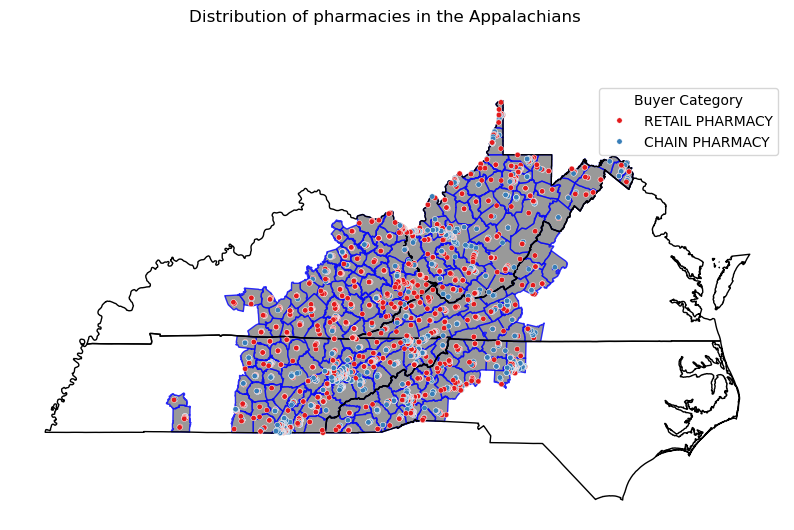

In [13]:
# I'd also like what county the buyer (pharmacy) is in 
# To do that I load the county shape file
# Let's see where these pharmacies are:

gdf_counties_appa = gpd.read_parquet('data/us_appa_counties.pq')
gdf_states_appa = gpd.read_parquet('data/us_appa_states.pq')
gdf_pharm = gpd.read_parquet('data/pharmacies_latlon.pq')

list_of_appa_count = gdf_counties_appa['geoid'].to_list()
gdf_pharm_appa=gdf_pharm[gdf_pharm['geoid'].isin(list_of_appa_count)]
gdf_pharm_appa=gdf_pharm_appa.rename(columns={'buyer_bus_act': 'Buyer Category'})
gdf_pharm_appa['Buyer Category']=gdf_pharm_appa['Buyer Category'].cat.remove_unused_categories()

fig,ax = plt.subplots(figsize=(10,6))
gdf_counties_appa.plot(ax=ax, color='grey', edgecolor='blue', alpha=0.8)
gdf_states_appa.plot(ax=ax, color='none', edgecolor='k')
sns.scatterplot(data=gdf_pharm_appa, x='lon', y='lat', hue='Buyer Category', palette='Set1',  ax=ax, legend='full', markers='o', s=15)
fig.suptitle('Distribution of pharmacies in the Appalachians')
ax.set_axis_off()

We notice that pharmacies are fairly spread out across the Appalachians with pockets of chain pharmacies and retail pharmacies more scattered across the region.

The Central Part of the Appalachian Mountains lies at the intersection of five states: West Virginia, Virginia, Tenneesse, North Carolina and Kentucky. Historically, the region used to have several mines as the main source of employment. Today, most mines have been shut down. To give an overview of county characteristics, I decide to plot a few maps to describe the demographic composition of this particular region. 

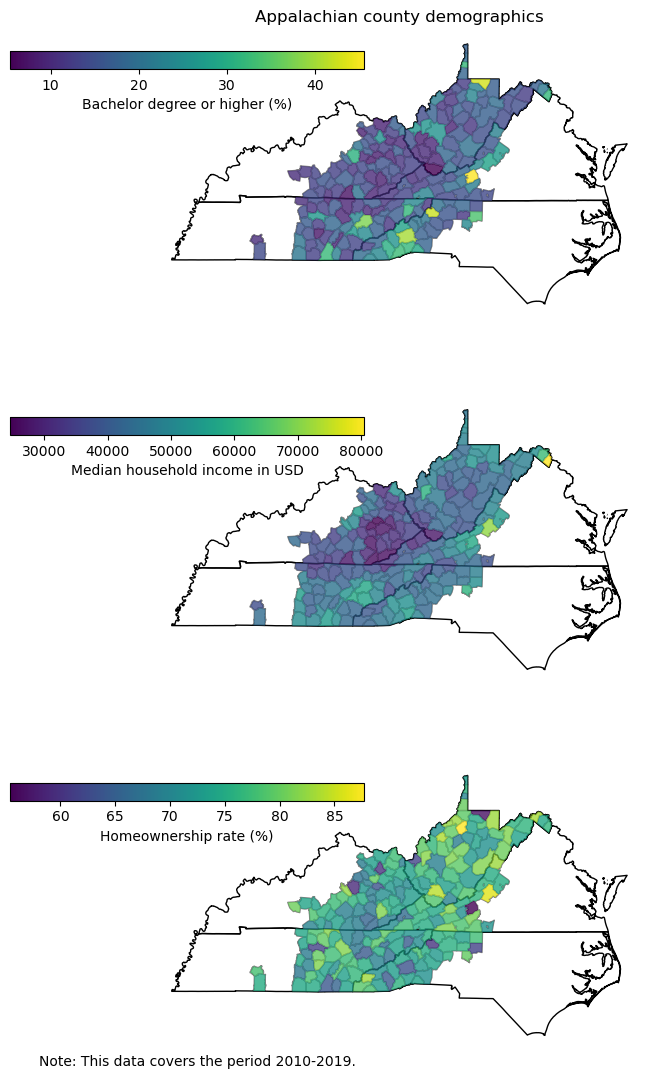

In [14]:
states_list = ['VA', 'WV', 'KY', 'TN', 'NC']
states_fips_list = ['51', '54', '21', '47', '37']

gdf_county_demo = utils.fetch_county_demographics(states=states_list, states_fips=states_fips_list, gdf_counties=gdf_counties_appa)
gdf_county_fig=utils.make_descrip_maps(gdf_county_demo, gdf_states_appa, title='Appalachian county demographics')
gdf_county_fig

We notice that educational levels in the Appalachians seem to be relatively low. Most counties have a share of no more than 20 percent of people with a bachelor's degree or higher. We do, however, notice small "pockets" of counties where the share of people with a bachelor's degree is around 40 percent. Unsurprisingly, this is around major cities such as Roanoke, Virgina (Roanoke County) and Asheville, North Carolina (Buncombe County).

This is correlated with the median household income. In counties with a lower share of people with a bachelor's degree, the median household income is between 30-40,000 USD. 

Interestingly, the homeownership rate (the share people who own their home) seem fairly high across the region. 75 percent or more people seem to own their home in most counties. However, there are counties with fairly low share of homeownership. Unsurprisingly, you find this in a major city like Roanoke, Virginia (Roanoke County). All things equal, I would expect to see a higher share of renters in major cities than in more rural areas.  

# 3. <a id='toc3_'></a>[Data analysis](#toc0_)
## 3.1. <a id='toc3_1_'></a>[Total dosage](#toc0_)

Starting off with the data analysis, I want to see the density of synthetic opioids (scaled by the MME-factor) shipped to a pharmacy by year.
In other words, I want to see whether it looks like pharmacies decide to have fewer opioid sent to them after 2010 (the reformulation of the synthetic opioid OxyContin).

(0.5, 50.0)

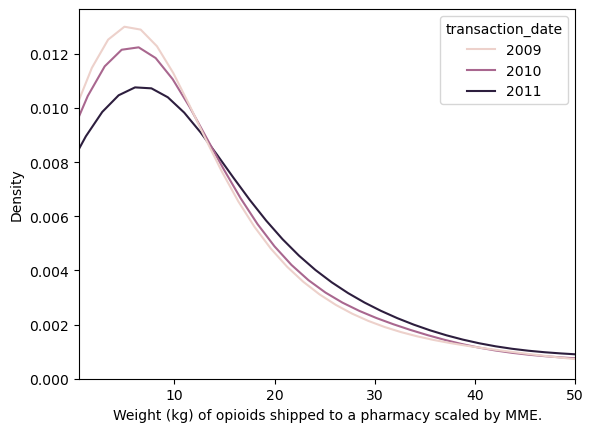

In [15]:
# I do a group-by: Group-by by each pharmacy in each year and sum their total MME-scaled opioid shipment
df_total_dos_per_pharm=lf.group_by(pl.col("buyer_dea_no"), pl.col("transaction_date").dt.year()).agg((pl.col("total_dos_mme").sum()/1000/1000).alias("total_dos_mme_kg")).collect().filter(pl.col("total_dos_mme_kg").is_between(0.5,300))

# Density plot of shipments by each year
plot = sns.kdeplot(data=df_total_dos_per_pharm, x='total_dos_mme_kg', hue="transaction_date")
plot.set_xlabel('Weight (kg) of opioids shipped to a pharmacy scaled by MME.')
plot.set_xlim(0.5,50)

Interestingly, it seems like that the density of opioids shipped to a pharmacy started to shift to the "right" after 2010. That is, the average pharmacy seem to have gotten more opioids after 2010.

Below, I make a line plot that shows the total quarterly synthetic opioid shipments in the Appalachians to get a clearer picture.

Text(0.5, 0.98, 'Quarterly synthetic opioid shipments in the Appalachians (2009-2011)')

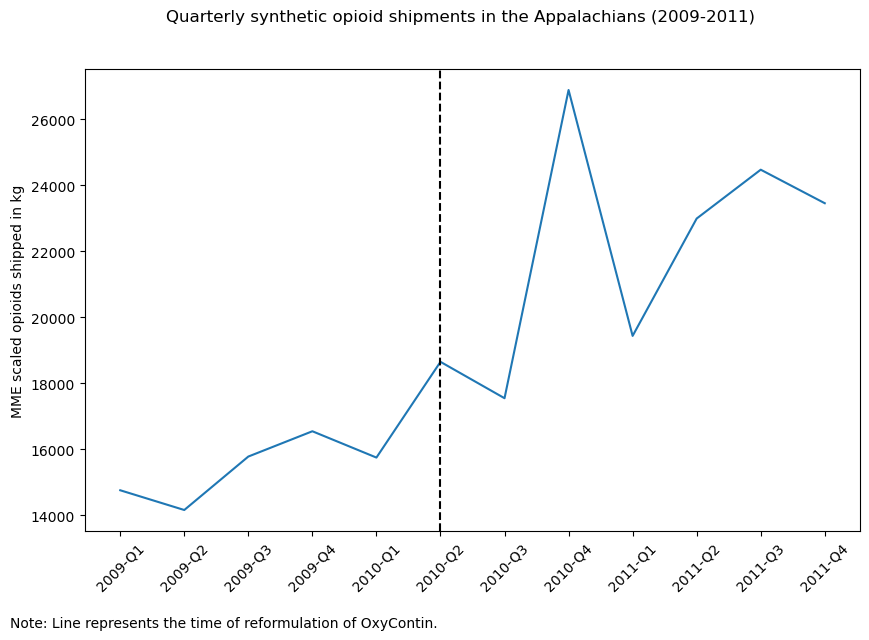

In [16]:
# Group-by by each calendar quarter and sum the total MME-scaled opioid shipment
df_total_dos_per_pharm=lf.group_by_dynamic('transaction_date', every='1q').agg(pl.col("total_dos_mme").sum()/1000/1000).collect()

# A helper function to get the correct x-labels on the plot
quarter_col=utils.make_helper_quarter_col(repeat=3)
df_total_dos_per_pharm=df_total_dos_per_pharm.with_columns(pl.col("transaction_date").dt.strftime("%Y-Q").alias("date_labels")).hstack(quarter_col)
df_total_dos_per_pharm=df_total_dos_per_pharm.with_columns(pl.concat_str(pl.col("date_labels", "repeated_numbers")))

xticks=df_total_dos_per_pharm.select(pl.col("date_labels")).to_series().to_list()

# Making the figure
fig,ax = plt.subplots(figsize=(10,6))
ax.plot('total_dos_mme', data=df_total_dos_per_pharm, label='Aggregated synthetic opioid shipments (kg)')
ax.set_xticks(range(len(xticks))) 
ax.set_xticklabels(xticks, rotation=45)
ax.axvline(x=5, color='k', linestyle='--')
ax.set_ylabel('MME scaled opioids shipped in kg')
fig.text(0.05, -0.05, 'Note: Line represents the time of reformulation of OxyContin.', fontsize=10)
fig.suptitle('Quarterly synthetic opioid shipments in the Appalachians (2009-2011)')

Again, it seems like pharmacies turn on the afterburner and actually increase the amount of opioids shipped after the OxyContin reformulation in 2010.

However, I suspect that variation across counties to be substantial. Below I make three maps that show the "per capita" amount of opioids shipped by year in each county. In other words, I sum the whole amount opioids shipped to a county and divide it by the county population.

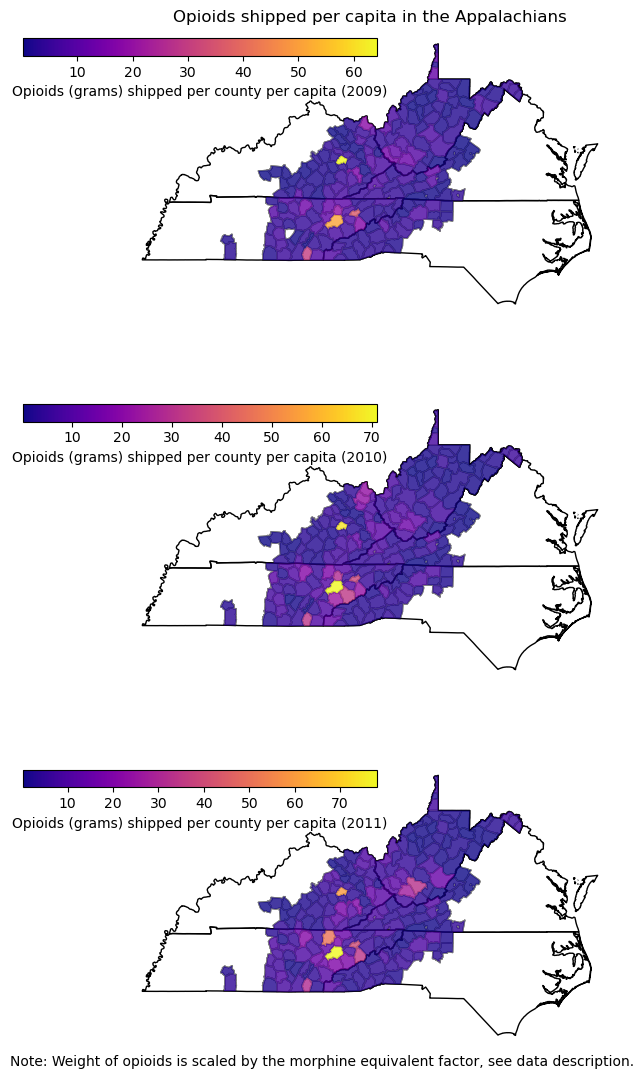

In [17]:
# I do a group-by: Group-by each county, sum the amount within 1 year and divide it by the county population
df_total_dos_per=lf.group_by_dynamic('transaction_date', every='1y', group_by='geoid').agg(pl.col("total_dos_mme").sum()/1000).collect()
df_total_dos_per=df_total_dos_per.with_columns(pl.col("transaction_date").dt.strftime("%Y").alias("date_labels"))

gdf_county_opi = utils.fetch_county_demographics(states=states_list, states_fips=states_fips_list, gdf_counties=gdf_counties_appa)
gdf_county_opi=gdf_county_opi.merge(df_total_dos_per.to_pandas(), left_on='geoid', right_on='geoid', how='right')
gdf_county_opi['MME_p_cap'] = (gdf_county_opi['total_dos_mme'])/gdf_county_opi['2010 Population']
map_of_shipments=utils.make_descrip_maps_shipment(gdf_states=gdf_states_appa, gdf_counties=gdf_county_opi, title='Opioids shipped per capita in the Appalachians')
map_of_shipments

# 4. <a id='toc4_'></a>[Conclusion](#toc0_)

There are two counties which seem to get an abnormal amount of opioids per capita! This is Knox County, Tennessesse and Lee County, Kentucky. They get over 60 grams of opioid pills per capita per year. 

This is not necessarily correlated with income levels. In Knox County, Tennessesse the median household income is around 57,000 USD and 37 percent have a bachelor or degree higher. In Lee County, Kentucky they earn around 25,000 USD and only 8.3 percent have a bachelor's degree or higher. Finally, it would be interesting to extend this analysis and look at potential 'pill mills' in Florida, for example.

In [18]:
# Make a map for the repo
opi_2010 = utils.make_descrip_maps_shipment_single(gdf_states=gdf_states_appa, gdf_counties=gdf_county_opi, title='Opioids shipped per capita in the Appalachians')
opi_2010.savefig('opi_2010.png', bbox_inches='tight')